Example using dask-gateway with a JupyterHub sandbox, intake-esm (on S3 NetCDF)


Author: A.Radhakrishnan, Feb 2021

using t2.xlarge

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
import numpy as np
%matplotlib inline

In [59]:
#%pip install ipywidgets

In [2]:
import sys
from dask_gateway import Gateway
gateway = Gateway()
clusters = gateway.list_clusters()
clusters

[]

In [3]:
if len(clusters) >0:
    cluster = gateway.connect(clusters[0].name)
    print("using existing connection")
else:
    from dask_gateway import GatewayCluster
    cluster = GatewayCluster()

In [4]:
from distributed import Client

client = Client(cluster)
client

#cluster.adapt(active=False)

Client Scheduler: gateway://traefik-dub-dask-gateway.dub:80/dub.9d059130af9249b49f6724a5a46119f8 Dashboard: /services/dask-gateway/clusters/dub.9d059130af9249b49f6724a5a46119f8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
options = gateway.cluster_options()  
options
#DO NOT CHANGE THIS FOR NOW

In [7]:
cluster.scale(2)

In [65]:
#pip install intake_esm intake netcdf4 %pip install dask_gateway

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. 
The catalog is updated on an on-demand basis for now. 
You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [8]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
#col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/community/esm-collection-spec-examples/esgf-world.json"

In [9]:
col = intake.open_esm_datastore(col_url)

In [10]:
#Try this first if you're trying it for the first time. cluster.scale(2)
cluster.adapt(minimum=1, maximum=10)  # scale between 0 and 6 workers

In [68]:
#Examples to just search for what we want from the catalog
expname_filter = ['historical']
table_id_filter = 'Amon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "ta"
ens_filter = "r1i1p1f1"
version_filter = "v20190726"
cat = col.search(experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [14]:
#Try this first if you're trying it for the first time. cluster.scale(2)
cluster.adapt(minimum=1, maximum=10)  # scale between 0 and 6 workers


In [70]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [71]:
hxr_gfdl_esm4 = dset_dict["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Amon"]

In [72]:
cat.df

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,NOAA-GFDL,GFDL-ESM4,historical,mon,atmos,Amon,r1i1p1f1,gr1,ta,185001-194912,v20190726,s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4...
1,CMIP6,NOAA-GFDL,GFDL-ESM4,historical,mon,atmos,Amon,r1i1p1f1,gr1,ta,195001-201412,v20190726,s3://esgf-world/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4...


! GLOBAL MEAN 
let hgtas = tas[x=@ave,y=@ave,d=1,l=529:780@ave]


In [73]:
ta = hxr_gfdl_esm4.ta

In [74]:
ta_mean = ta.mean(dim='time')

In [75]:
#%time hgtas2d = ta.isel(plev=8).plot()

(array([ 14253.,  53702., 264629., 185306., 115666.,  66000., 123280.,
         58282.,  53592.,  25901.]),
 array([189.09856, 200.48802, 211.87749, 223.26695, 234.65642, 246.0459 ,
        257.43536, 268.82483, 280.2143 , 291.60376, 302.99323],
       dtype=float32),
 <BarContainer object of 10 artists>)

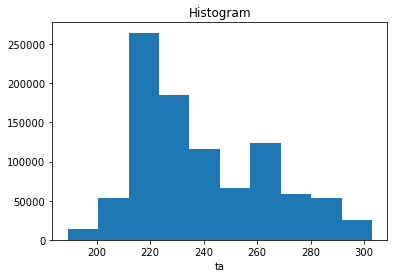

In [76]:
ta_mean.plot()

In [77]:
#Examples to just search for what we want from the catalog
expname_filter = ['historical']
table_id_filter = 'Omon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "thetao"
ens_filter = "r1i1p1f1"
#version_filter = "v20190726"
grid_label="gn"
cat = col.search(grid_label="gn",experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter,version="v20190726")

In [91]:
cat

,unique
project,1
institute,1
model,1
experiment_id,1
frequency,1
modeling_realm,1
mip_table,1
ensemble_member,1
grid_label,1
variable,1


In [78]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [82]:
ds = dset_dict['CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon']

In [92]:
ds

<xarray.Dataset>
Dimensions:          (ensemble_member: 1, lev: 35, time: 1980, x: 720, y: 576)
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * lev              (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Data variables:
    thetao           (ensemble_member, time, lev, y, x) float32 dask.array<chunksize=(1, 1, 35, 576, 720), meta=np.ndarray>
Attributes:
    activity_id:             CMIP
    realization_index:       [1]
    initialization_index:    [1]
    grid:                    ocean data on native grid tripolar - nominal 0.5...
    data_specs_version:      01.00.27
    branch_method:           standard
    sub_experiment:          none
    history:                 File was processed by fremetar (GFDL analog of C...
    branch_time_in_child:    [0.]
    parent_mip_era:          CMIP6
    grid_label:              gn
    parent_activity_id:      CMIP
    experiment_id:           historical
    intake_esm_varname:      ['thetao']
    realm:                   ocean
    parent_source_id:        GFDL-ESM4
    comment:                 <null ref>
    table_id:                Omon
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    external_variables:      areacello volcello
    frequency:               mon
    parent_experiment_id:    piControl
    source_type:             AOGCM AER CHEM BGC
    physics_index:           [1]
    contact:                 gfdl.climate.model.info@noaa.gov
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.G...
    mip_era:                 CMIP6
    creation_date:           2019-08-06T06:52:22Z
    references:              see further_info_url attribute
    product:                 model-output
    forcing_index:           [1]
    parent_time_units:       days since 0001-1-1
    source:                  GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-sphe...
    variant_label:           r1i1p1f1
    source_id:               GFDL-ESM4
    variable_id:             thetao
    sub_experiment_id:       none
    institution_id:          NOAA-GFDL
    parent_variant_label:    r1i1p1f1
    experiment:              all-forcing simulation of the recent past
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    branch_time_in_parent:   [36500.]
    tracking_id:             hdl:21.14100/6e88fbac-ee16-434e-88b4-92bd18c5300...
    institution:             National Oceanic and Atmospheric Administration,...
    nominal_resolution:      50 km
    title:                   NOAA GFDL GFDL-ESM4 model output prepared for CM...
    variant_info:            N/A
    intake_esm_dataset_key:  CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon

In [87]:
thetao = ds.thetao

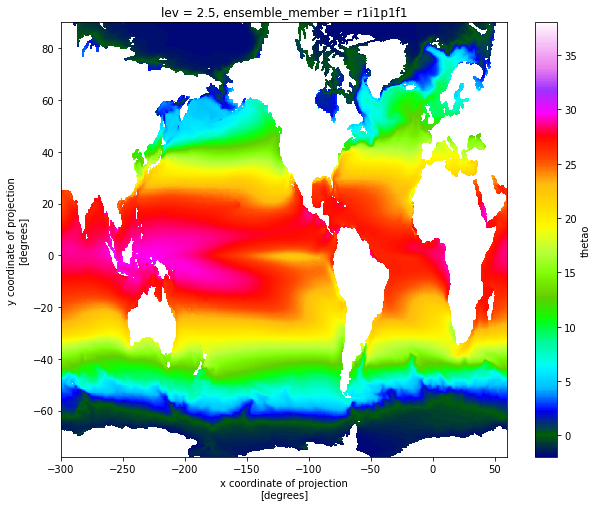

In [90]:
thetao_mean = thetao.sel(lev=2.5).mean(dim='time')
thetao_mean.plot(figsize=[10,8], vmin=-2, vmax=38, cmap='gist_ncar')

In [11]:
#Examples to just search for what we want from the catalog
expname_filter = ['piControl']
table_id_filter = 'Omon'
model_filter = 'GFDL-ESM4'
variable_id_filter = "thetao"
ens_filter = "r1i1p1f1"
cat = col.search(grid_label="gn",experiment_id=expname_filter, mip_table=table_id_filter,model=model_filter,variable=variable_id_filter)

In [12]:
print(cat)

<gfdltest catalog with 1 dataset(s) from 25 asset(s)>


In [13]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 1}},storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [14]:
ds = dset_dict['CMIP6.NOAA-GFDL.GFDL-ESM4.piControl.Omon']

In [15]:
thetao = ds.thetao 
thetao_mean = thetao.sel(lev=2.5).mean(dim='time')


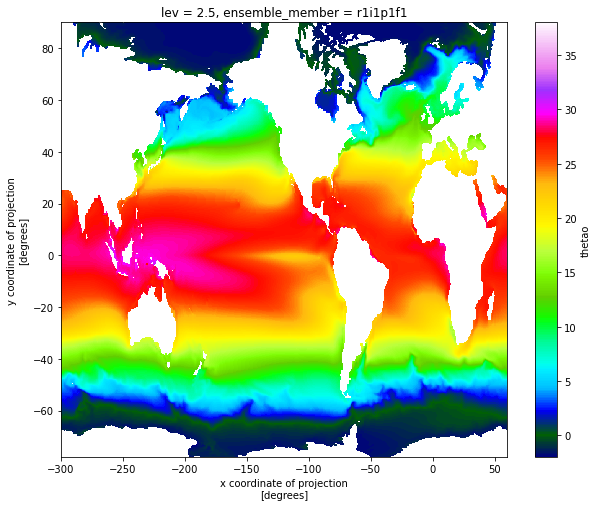

In [16]:
thetao_mean.plot(figsize=[10,8], vmin=-2, vmax=38, cmap='gist_ncar')

In [82]:
cluster.close()
client.close()
#you can also set an auto close when you create a cluster , refer dask gateway docs